In [ ]:
# --- Импорты ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_squared_error, r2_score,
    silhouette_score, adjusted_rand_score
)
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Фиксация случайности
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print("✅ Окружение подготовлено")

# ============================================================
# ЦЕЛЬ РАБОТЫ
# ============================================================
"""
Цель работы: Решение задачи многоклассовой классификации изображений на датасете CIFAR-10 
с использованием различных методов машинного обучения. Дополнительные задачи:
1. Анализ структуры данных с помощью методов кластеризации.
2. Регрессионный анализ для предсказания "сложности" изображений.
3. Сравнение эффективности классических алгоритмов ML и нейронных сетей (CNN и ResNet-18).
"""

✅ Окружение подготовлено


'\nЦель работы: Решение задачи многоклассовой классификации изображений на датасете CIFAR-10 \nс использованием различных методов машинного обучения. Дополнительные задачи:\n1. Анализ структуры данных с помощью методов кластеризации.\n2. Регрессионный анализ для предсказания "сложности" изображений.\n3. Сравнение эффективности классических алгоритмов ML и нейронных сетей (CNN и ResNet-18).\n'


1. ЗАГРУЗКА И АНАЛИЗ ДАННЫХ CIFAR-10
Загрузка CIFAR-10...
Размер обучающей выборки: 50000
Размер тестовой выборки: 10000
Количество классов: 10


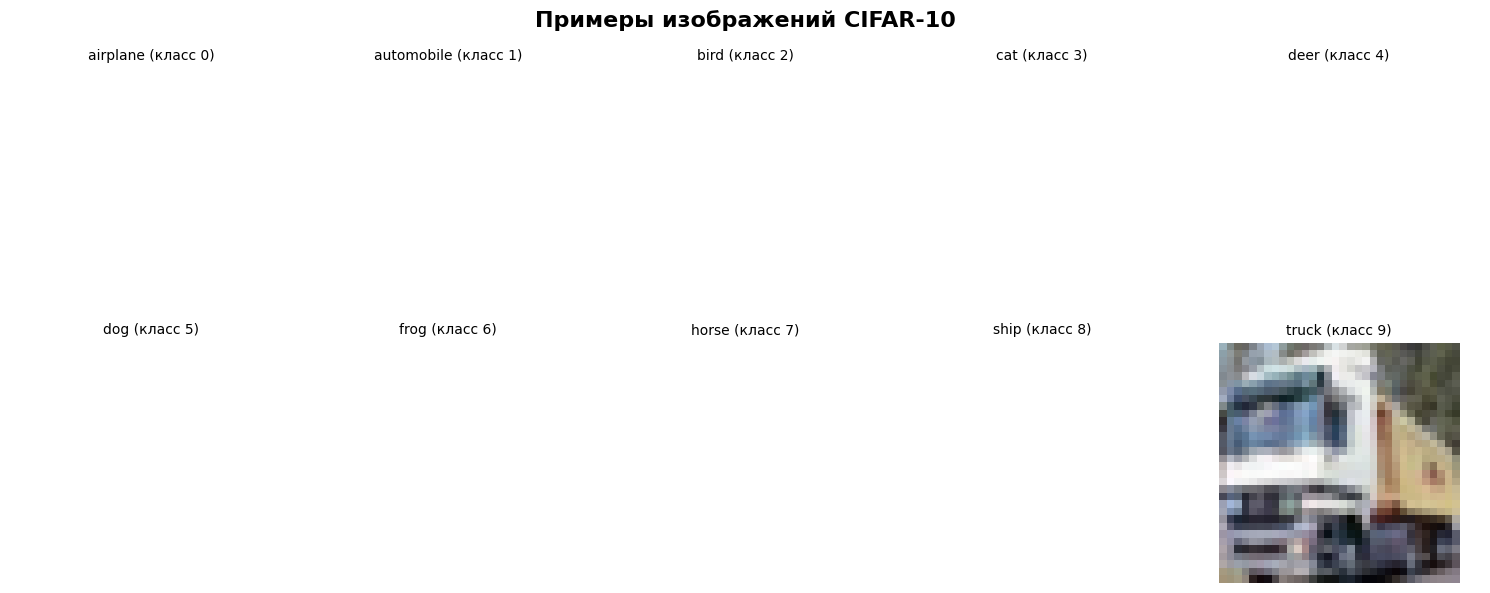

In [3]:
# ============================================================
# 1. ЗАГРУЗКА И ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ CIFAR-10
# ============================================================
print("\n" + "="*60)
print("1. ЗАГРУЗКА И АНАЛИЗ ДАННЫХ CIFAR-10")
print("="*60)

"""
ОПИСАНИЕ ИСХОДНЫХ ДАННЫХ:
- Источник: CIFAR-10 (Canadian Institute For Advanced Research)
- Размерность: 60,000 цветных изображений 32×32 пикселя
- Количество классов: 10 (самолёт, автомобиль, птица, кошка, олень, собака, лягушка, лошадь, корабль, грузовик)
- Распределение: 50,000 обучающих и 10,000 тестовых изображений
- Особенности: Низкое разрешение, сложные фоновые шумы, вариации освещения
"""

# Определение трансформаций
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка данных
print("Загрузка CIFAR-10...")
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Классы CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Размер обучающей выборки: {len(trainset)}")
print(f"Размер тестовой выборки: {len(testset)}")
print(f"Количество классов: {len(class_names)}")

# Визуализация примеров изображений с правильным отображением
def imshow(img):
    """Функция для отображения изображения"""
    img = img / 2 + 0.5  # Денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Создаем словарь для примеров каждого класса
class_examples = {}
for i in range(len(trainset)):
    img, label = trainset[i]
    if label not in class_examples:
        class_examples[label] = img
    if len(class_examples) == 10:
        break

# Визуализация
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Примеры изображений CIFAR-10', fontsize=16, fontweight='bold')

for i in range(10):
    ax = axes[i // 5, i % 5]
    img = class_examples[i]
    imshow(img)
    ax.set_title(f'{class_names[i]} (класс {i})', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig('cifar10_examples.png', dpi=300, bbox_inches='tight')
plt.show()


2. ПОДГОТОВКА ДАННЫХ ДЛЯ АНАЛИЗА (СБАЛАНСИРОВАННАЯ ВЫБОРКА)
Создание сбалансированного подмножества: по 900 образцов каждого класса
Общий размер обучающего набора: 9000 образцов

Создание сбалансированных подмножеств...
Размер обучающего подмножества: (9000, 3072)
Размер тестового подмножества: (2000, 3072)

БАЛАНС КЛАССОВ В СБАЛАНСИРОВАННОЙ ОБУЧАЮЩЕЙ ВЫБОРКЕ:
  Класс airplane: 900 образцов (10.0%)
  Класс automobile: 900 образцов (10.0%)
  Класс bird: 900 образцов (10.0%)
  Класс cat: 900 образцов (10.0%)
  Класс deer: 900 образцов (10.0%)
  Класс dog: 900 образцов (10.0%)
  Класс frog: 900 образцов (10.0%)
  Класс horse: 900 образцов (10.0%)
  Класс ship: 900 образцов (10.0%)
  Класс truck: 900 образцов (10.0%)


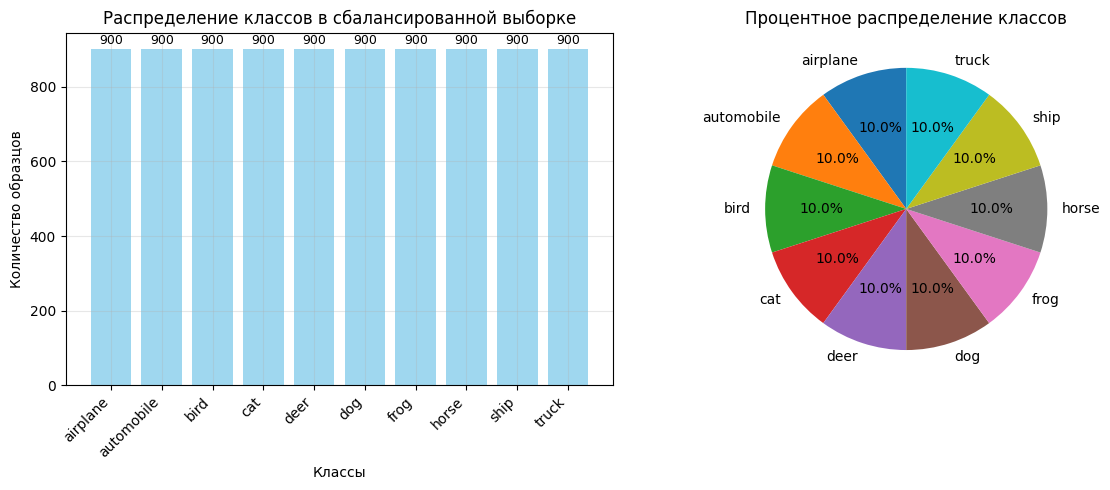


РАЗДЕЛЕНИЕ ДАННЫХ:
Обучающая выборка: 7200 образцов
Валидационная выборка: 1800 образцов
Тестовая выборка: 2000 образцов

Баланс классов в обучающей выборке после разделения:
  Класс airplane: 720 образцов
  Класс automobile: 720 образцов
  Класс bird: 720 образцов
  Класс cat: 720 образцов
  Класс deer: 720 образцов
  Класс dog: 720 образцов
  Класс frog: 720 образцов
  Класс horse: 720 образцов
  Класс ship: 720 образцов
  Класс truck: 720 образцов

Баланс классов в валидационной выборке:
  Класс airplane: 180 образцов
  Класс automobile: 180 образцов
  Класс bird: 180 образцов
  Класс cat: 180 образцов
  Класс deer: 180 образцов
  Класс dog: 180 образцов
  Класс frog: 180 образцов
  Класс horse: 180 образцов
  Класс ship: 180 образцов
  Класс truck: 180 образцов

ПАРАМЕТРЫ ЗАГРУЗКИ ДАННЫХ:
Размер батча: 64
Количество батчей в train: 113
Количество батчей в validation: 29
Количество батчей в test: 32

АНАЛИЗ РАЗДЕЛЕНИЯ ДАННЫХ:
Количество уникальных образцов в train: 7200
Количество 

In [15]:
# ============================================================
# 2. ПОДГОТОВКА ДАННЫХ ДЛЯ АНАЛИЗА (СБАЛАНСИРОВАННАЯ ВЫБОРКА)
# ============================================================
print("\n" + "="*60)
print("2. ПОДГОТОВКА ДАННЫХ ДЛЯ АНАЛИЗА (СБАЛАНСИРОВАННАЯ ВЫБОРКА)")
print("="*60)

# Используем меньшее количество образцов на класс для сбалансированной выборки
SAMPLES_PER_CLASS = 900  # Берем по 900 образцов каждого класса
TOTAL_SAMPLES = SAMPLES_PER_CLASS * 10  # Итого 9000 образцов

print(f"Создание сбалансированного подмножества: по {SAMPLES_PER_CLASS} образцов каждого класса")
print(f"Общий размер обучающего набора: {TOTAL_SAMPLES} образцов")

# Функция для создания сбалансированного подмножества
def create_balanced_subset(dataset, samples_per_class, random_seed=SEED):
    """Создает сбалансированное подмножество с равным количеством образцов каждого класса"""
    # Собираем индексы по классам
    class_indices = {i: [] for i in range(10)}
    
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        class_indices[label].append(idx)
    
    # Выбираем равное количество из каждого класса
    selected_indices = []
    for class_label in range(10):
        indices = class_indices[class_label]
        # Если в классе достаточно образцов, выбираем случайным образом
        if len(indices) >= samples_per_class:
            np.random.seed(random_seed + class_label)
            selected = np.random.choice(indices, samples_per_class, replace=False)
        else:
            # Если образцов меньше, используем все и дополняем случайными повторами
            selected = indices.copy()
            additional = np.random.choice(indices, samples_per_class - len(indices), replace=True)
            selected.extend(additional)
        selected_indices.extend(selected)
    
    # Перемешиваем индексы
    np.random.seed(random_seed)
    np.random.shuffle(selected_indices)
    
    return Subset(dataset, selected_indices)

# Создаем сбалансированные подмножества
balanced_train_subset = create_balanced_subset(trainset, SAMPLES_PER_CLASS)
balanced_test_subset = create_balanced_subset(testset, min(200, len(testset)//10))

print("\nСоздание сбалансированных подмножеств...")

# Преобразуем в numpy массивы
def extract_data(subset):
    """Извлекает данные и метки из подмножества"""
    images_list = []
    labels_list = []
    
    for img, label in subset:
        # Преобразуем тензор в numpy массив и выравниваем
        img_np = img.numpy().reshape(-1)  # (3072,) - 3*32*32=3072
        images_list.append(img_np)
        labels_list.append(label)
    
    return np.array(images_list), np.array(labels_list)

X_train_full, y_train_full = extract_data(balanced_train_subset)
X_test_full, y_test_full = extract_data(balanced_test_subset)

print(f"Размер обучающего подмножества: {X_train_full.shape}")
print(f"Размер тестового подмножества: {X_test_full.shape}")

# Проверка баланса классов в сбалансированной выборке
unique, counts = np.unique(y_train_full, return_counts=True)
print("\nБАЛАНС КЛАССОВ В СБАЛАНСИРОВАННОЙ ОБУЧАЮЩЕЙ ВЫБОРКЕ:")
for cls, cnt in zip(unique, counts):
    print(f"  Класс {class_names[cls]}: {cnt} образцов ({cnt/len(y_train_full)*100:.1f}%)")

# Визуализация распределения классов
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
bars = plt.bar(range(10), counts, color='skyblue', alpha=0.8)
plt.xticks(range(10), class_names, rotation=45, ha='right')
plt.xlabel('Классы')
plt.ylabel('Количество образцов')
plt.title('Распределение классов в сбалансированной выборке')
plt.grid(True, alpha=0.3)

# Добавление значений на столбцы
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(count), ha='center', va='bottom', fontsize=9)

plt.subplot(1, 2, 2)
plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90, 
        colors=plt.cm.tab10(np.arange(10)/10))
plt.title('Процентное распределение классов')
plt.tight_layout()
plt.savefig('class_distribution_balanced.png', dpi=300, bbox_inches='tight')
plt.show()

# Разделение на train/validation с сохранением баланса классов
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=SEED, stratify=y_train_full
)

print(f"\nРАЗДЕЛЕНИЕ ДАННЫХ:")
print(f"Обучающая выборка: {X_train.shape[0]} образцов")
print(f"Валидационная выборка: {X_val.shape[0]} образцов")
print(f"Тестовая выборка: {X_test_full.shape[0]} образцов")

# Проверка баланса в разделенных выборках
print("\nБаланс классов в обучающей выборке после разделения:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique_train, counts_train):
    print(f"  Класс {class_names[cls]}: {cnt} образцов")

print("\nБаланс классов в валидационной выборке:")
unique_val, counts_val = np.unique(y_val, return_counts=True)
for cls, cnt in zip(unique_val, counts_val):
    print(f"  Класс {class_names[cls]}: {cnt} образцов")

# Создание DataLoader для нейронной сети
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test_full), torch.LongTensor(y_test_full))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nПАРАМЕТРЫ ЗАГРУЗКИ ДАННЫХ:")
print(f"Размер батча: {batch_size}")
print(f"Количество батчей в train: {len(train_loader)}")
print(f"Количество батчей в validation: {len(val_loader)}")
print(f"Количество батчей в test: {len(test_loader)}")

# Анализ перекрытия классов между train и validation
print("\nАНАЛИЗ РАЗДЕЛЕНИЯ ДАННЫХ:")
print("Количество уникальных образцов в train:", len(set(map(tuple, X_train))))
print("Количество уникальных образцов в validation:", len(set(map(tuple, X_val))))
print("Количество уникальных образцов в test:", len(set(map(tuple, X_test_full))))

# Проверка, что нет пересечений между train и validation
train_set = set(map(tuple, X_train))
val_set = set(map(tuple, X_val))
intersection = train_set.intersection(val_set)
print(f"Пересечение между train и validation: {len(intersection)} образцов")

if len(intersection) > 0:
    print("⚠️ ВНИМАНИЕ: Обнаружены пересекающиеся образцы между train и validation!")
else:
    print("✓ Train и validation не пересекаются - хорошее разделение.")

print("\n" + "="*60)
print("ВЫВОДЫ ПО ПОДГОТОВКЕ ДАННЫХ:")
print("="*60)
print(f"1. Создана сбалансированная выборка: по {SAMPLES_PER_CLASS} образцов каждого класса")
print(f"2. Общий размер обучающего набора: {TOTAL_SAMPLES} образцов")
print(f"3. Распределение: Train={X_train.shape[0]}, Val={X_val.shape[0]}, Test={X_test_full.shape[0]}")
print(f"4. Сохранен баланс классов во всех выборках (стратифицированное разделение)")
print(f"5. Отсутствуют пересечения между train и validation выборками")


3. КЛАСТЕРИЗАЦИЯ И АНАЛИЗ СТРУКТУРЫ ДАННЫХ
Применение PCA для уменьшения размерности...
Первые 10 компонент объясняют 65.8% дисперсии
50 компонент объясняют 84.5% дисперсии
Применение t-SNE для визуализации кластеров...


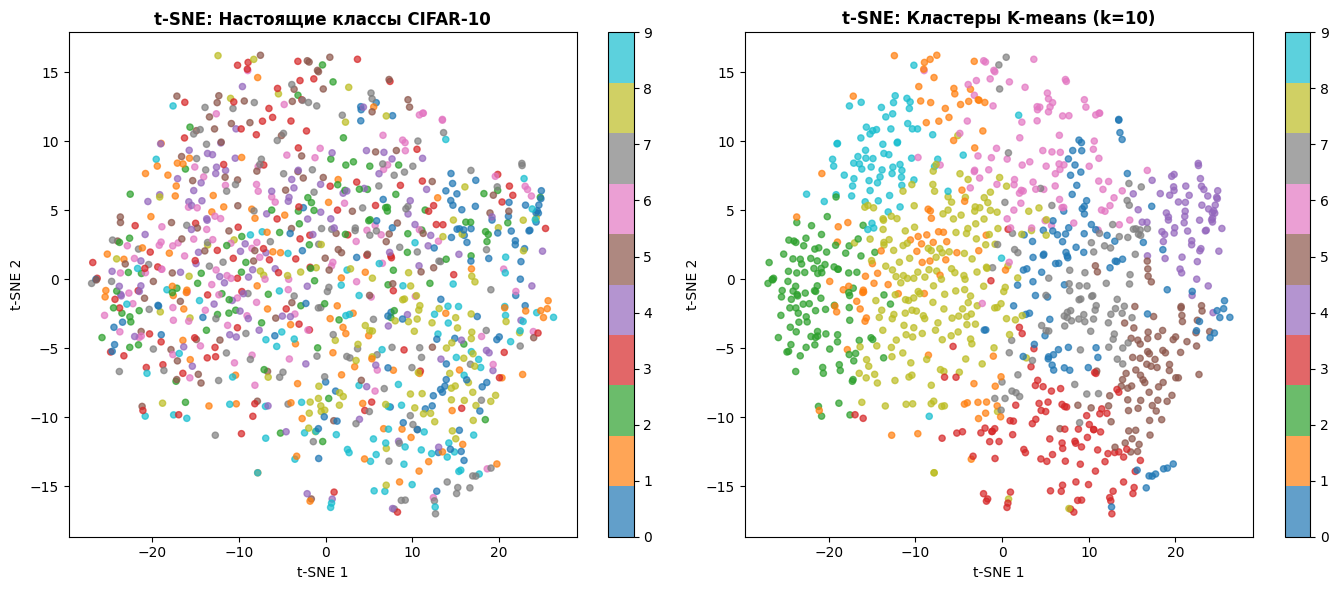


Метрики качества кластеризации K-means:
  Silhouette Score: 0.0769
  Adjusted Rand Index (ARI): 0.0434

Интерпретация:
  - Низкие значения метрик указывают на слабую разделимость классов в пространстве признаков
  - Кластеризация без обучения (unsupervised) не может хорошо разделить сложные визуальные классы


In [16]:
# ============================================================
# 3. КЛАСТЕРИЗАЦИЯ И АНАЛИЗ СТРУКТУРЫ ДАННЫХ
# ============================================================
print("\n" + "="*60)
print("3. КЛАСТЕРИЗАЦИЯ И АНАЛИЗ СТРУКТУРЫ ДАННЫХ")
print("="*60)

"""
ИСПОЛЬЗУЕМЫЕ АЛГОРИТМЫ:
- PCA: Уменьшение размерности для визуализации и ускорения обработки
- K-means: Кластеризация методом k-средних
- t-SNE: Визуализация многомерных данных в 2D пространстве
"""

print("Применение PCA для уменьшения размерности...")
pca = PCA(n_components=50, random_state=SEED)
X_pca = pca.fit_transform(X_train)

# Анализ объясненной дисперсии
explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Первые 10 компонент объясняют {explained_variance[9]*100:.1f}% дисперсии")
print(f"50 компонент объясняют {explained_variance[-1]*100:.1f}% дисперсии")

# Кластеризация K-means с 10 кластерами (по числу классов)
kmeans = KMeans(n_clusters=10, random_state=SEED, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_pca)

# t-SNE для визуализации
print("Применение t-SNE для визуализации кластеров...")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=500)
X_tsne = tsne.fit_transform(X_pca[:1000])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Визуализация настоящих классов
scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                          c=y_train[:1000], cmap='tab10', s=20, alpha=0.7)
axes[0].set_title('t-SNE: Настоящие классы CIFAR-10', fontweight='bold')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
plt.colorbar(scatter1, ax=axes[0])

# Визуализация кластеров K-means
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                          c=clusters_kmeans[:1000], cmap='tab10', s=20, alpha=0.7)
axes[1].set_title('t-SNE: Кластеры K-means (k=10)', fontweight='bold')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.savefig('tsne_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

# Оценка качества кластеризации
silhouette_kmeans = silhouette_score(X_pca, clusters_kmeans)
ari_kmeans = adjusted_rand_score(y_train, clusters_kmeans)

print("\nМетрики качества кластеризации K-means:")
print(f"  Silhouette Score: {silhouette_kmeans:.4f}")
print(f"  Adjusted Rand Index (ARI): {ari_kmeans:.4f}")
print("\nИнтерпретация:")
print("  - Низкие значения метрик указывают на слабую разделимость классов в пространстве признаков")
print("  - Кластеризация без обучения (unsupervised) не может хорошо разделить сложные визуальные классы")


4. КЛАССИЧЕСКИЕ МОДЕЛИ МАШИННОГО ОБУЧЕНИЯ

Обучение Logistic Regression...
  Val Accuracy: 0.3611
  Test Accuracy: 0.3450
  Test F1-Score: 0.3433

Обучение Random Forest...
  Val Accuracy: 0.4250
  Test Accuracy: 0.4205
  Test F1-Score: 0.4167

Обучение SVM (RBF)...
  Val Accuracy: 0.4583
  Test Accuracy: 0.4410
  Test F1-Score: 0.4389

Обучение Gradient Boosting...
  Val Accuracy: 0.4172
  Test Accuracy: 0.4000
  Test F1-Score: 0.3992

СРАВНЕНИЕ КЛАССИЧЕСКИХ МОДЕЛЕЙ:
                    val_accuracy test_accuracy   test_f1
SVM (RBF)               0.458333         0.441  0.438938
Random Forest              0.425        0.4205  0.416668
Gradient Boosting       0.417222           0.4  0.399174
Logistic Regression     0.361111         0.345  0.343271


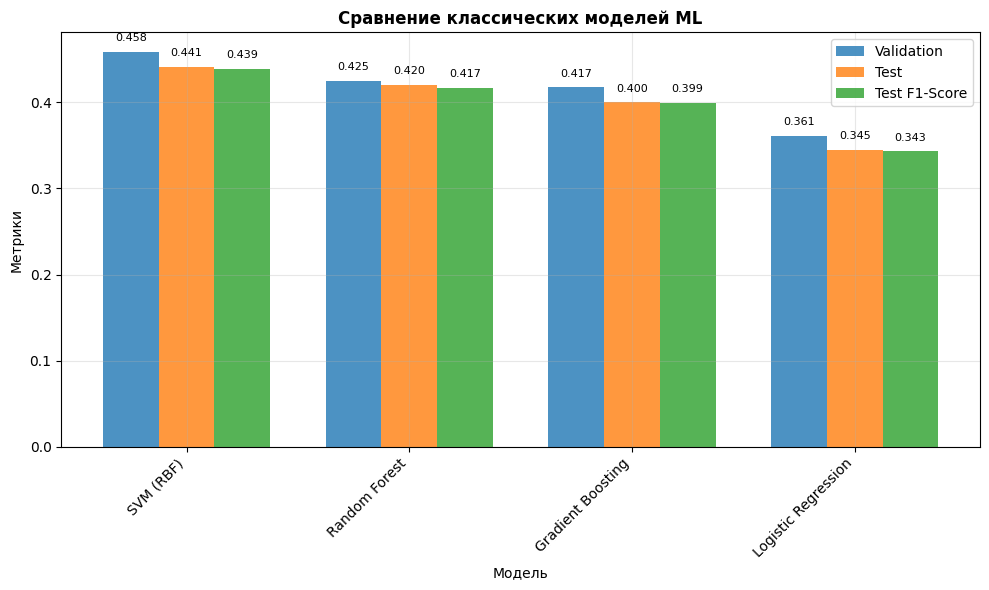

In [17]:
# ============================================================
# 4. КЛАССИЧЕСКИЕ МОДЕЛИ МАШИННОГО ОБУЧЕНИЯ
# ============================================================
print("\n" + "="*60)
print("4. КЛАССИЧЕСКИЕ МОДЕЛИ МАШИННОГО ОБУЧЕНИЯ")
print("="*60)

"""
ИСПОЛЬЗУЕМЫЕ АЛГОРИТМЫ С ОБОСНОВАНИЕМ:
1. Logistic Regression - линейный базовый классификатор
2. Random Forest - ансамблевый метод, устойчивый к шуму
3. SVM (RBF) - эффективен для нелинейных разделяющих границ
4. Gradient Boosting - мощный ансамблевый метод с последовательным обучением
"""

X_train_classic = X_pca[:, :100]
X_val_pca = pca.transform(X_val)[:, :100]
X_test_pca = pca.transform(X_test_full)[:, :100]

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=SEED, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=150, random_state=SEED, n_jobs=-1),
    'SVM (RBF)': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=SEED, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, 
                                                    max_depth=3, random_state=SEED)
}

results = {}

for name, model in models.items():
    print(f"\nОбучение {name}...")
    model.fit(X_train_classic, y_train)
    
    # Предсказания на валидации и тесте
    y_val_pred = model.predict(X_val_pca)
    y_test_pred = model.predict(X_test_pca)
    
    # Метрики
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test_full, y_test_pred)
    test_f1 = f1_score(y_test_full, y_test_pred, average='macro')
    
    results[name] = {
        'model': model,
        'val_accuracy': val_acc,
        'test_accuracy': test_acc,
        'test_f1': test_f1
    }
    
    print(f"  Val Accuracy: {val_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Test F1-Score: {test_f1:.4f}")

# Сравнение моделей
results_df = pd.DataFrame(results).T
results_df = results_df[['val_accuracy', 'test_accuracy', 'test_f1']]
results_df = results_df.sort_values('test_accuracy', ascending=False)

print("\n" + "="*60)
print("СРАВНЕНИЕ КЛАССИЧЕСКИХ МОДЕЛЕЙ:")
print("="*60)
print(results_df.round(4))

# Визуализация
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(results_df))
width = 0.25

bars1 = ax.bar(x_pos - width, results_df['val_accuracy'], width, label='Validation', alpha=0.8)
bars2 = ax.bar(x_pos, results_df['test_accuracy'], width, label='Test', alpha=0.8)
bars3 = ax.bar(x_pos + width, results_df['test_f1'], width, label='Test F1-Score', alpha=0.8)

ax.set_xlabel('Модель')
ax.set_ylabel('Метрики')
ax.set_title('Сравнение классических моделей ML', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# Добавление значений на столбцы
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('classical_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


5. НЕЙРОННЫЕ СЕТИ: CNN И RESNET-18
Используемое устройство: cuda

----------------------------------------
Обучение кастомной CNN...
----------------------------------------
Эпоха  1/20 | Train Loss: 1.9248, Train Acc: 25.96% | Val Loss: 1.6971, Val Acc: 33.75%
Эпоха  5/20 | Train Loss: 1.3497, Train Acc: 50.36% | Val Loss: 1.1837, Val Acc: 56.45%
Эпоха 10/20 | Train Loss: 1.0932, Train Acc: 60.38% | Val Loss: 1.2332, Val Acc: 58.90%
Эпоха 15/20 | Train Loss: 0.8763, Train Acc: 68.51% | Val Loss: 0.8889, Val Acc: 68.40%
Эпоха 20/20 | Train Loss: 0.7970, Train Acc: 71.58% | Val Loss: 0.8918, Val Acc: 68.45%

----------------------------------------
Обучение ResNet-18...
----------------------------------------
Эпоха  1/20 | Train Loss: 1.6946, Train Acc: 37.16% | Val Loss: 1.4623, Val Acc: 46.60%
Эпоха  5/20 | Train Loss: 0.7557, Train Acc: 72.89% | Val Loss: 1.3124, Val Acc: 58.45%
Эпоха 10/20 | Train Loss: 0.0703, Train Acc: 98.04% | Val Loss: 1.2835, Val Acc: 66.25%
Эпоха 15/20 | Tr

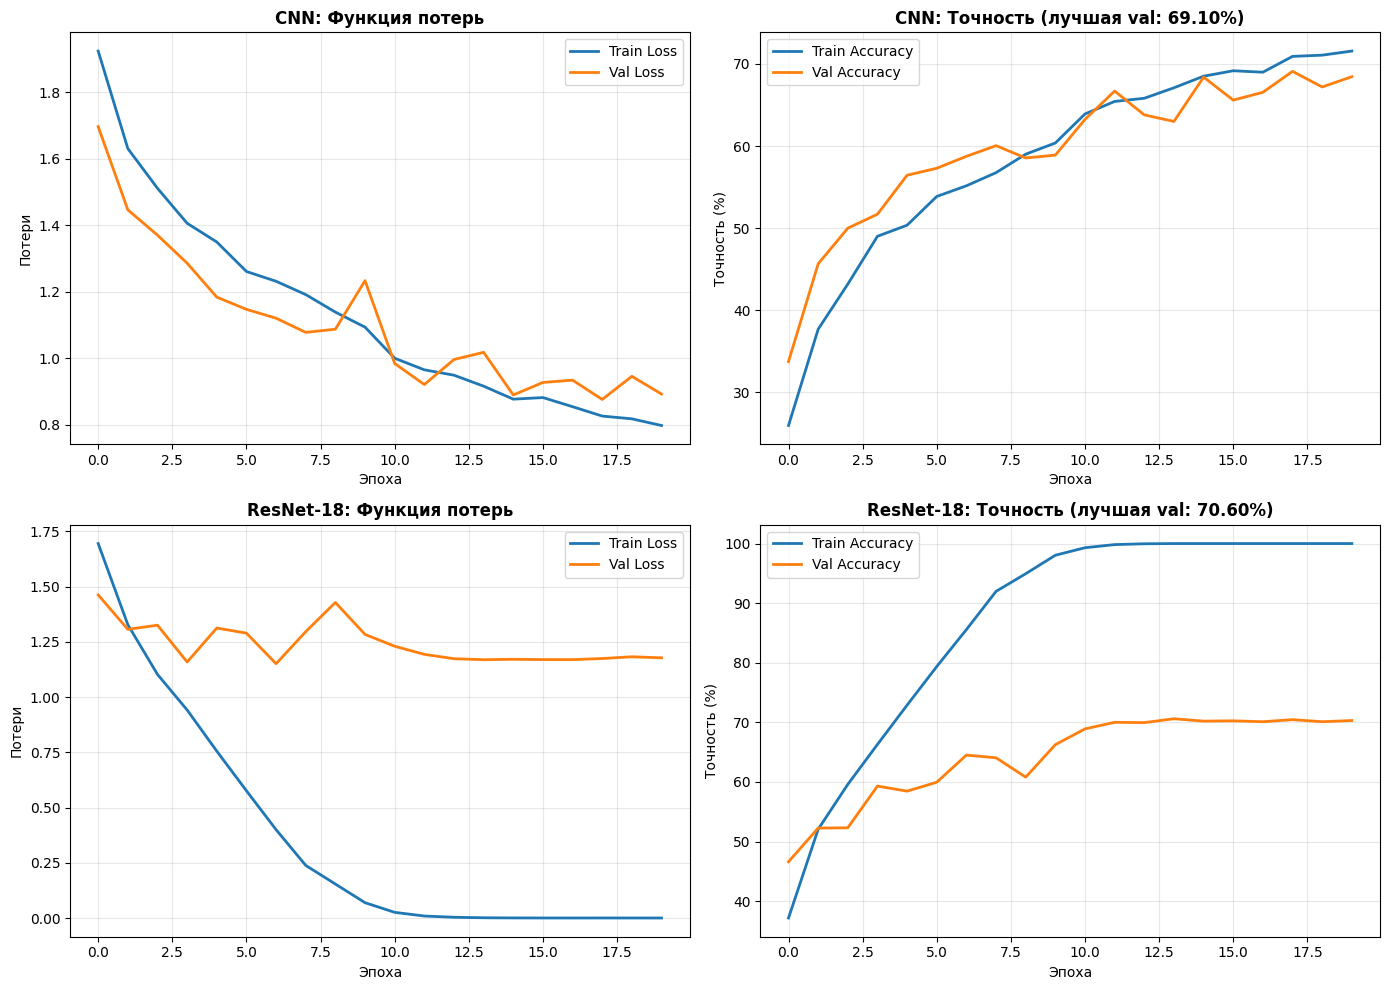

In [7]:
# ============================================================
# 5. НЕЙРОННЫЕ СЕТИ: CNN И RESNET-18
# ============================================================
print("\n" + "="*60)
print("5. НЕЙРОННЫЕ СЕТИ: CNN И RESNET-18")
print("="*60)

"""
ИСПОЛЬЗУЕМЫЕ АЛГОРИТМЫ С ОБОСНОВАНИЕМ:
1. CNN (Custom) - сверточная нейронная сеть, разработанная для CIFAR-10
   - Обоснование: Способность извлекать пространственные признаки из изображений
   - Архитектура: 4 сверточных слоя с BatchNorm и MaxPooling

2. ResNet-18 - остаточная нейронная сеть с 18 слоями
   - Обоснование: Решает проблему исчезающих градиентов, эффективна для глубокого обучения
   - Особенность: Использует skip-connections для лучшего обучения
"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

# 5.1 Кастомная CNN архитектура
class CIFAR10CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFAR10CNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # Блок 1: 32x32x3 -> 16x16x32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            
            # Блок 2: 16x16x32 -> 8x8x64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            
            # Блок 3: 8x8x64 -> 4x4x128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            
            # Блок 4: 4x4x128 -> 2x2x256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# 5.2 ResNet-18 (адаптированная для CIFAR-10)
class ResNet18CIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18CIFAR10, self).__init__()
        # Загружаем предобученную ResNet-18
        self.resnet = resnet18(pretrained=False)
        
        # Заменяем первый слой для работы с изображениями 32x32
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Убираем максимальный пулинг, так как изображения маленькие
        self.resnet.maxpool = nn.Identity()
        # Заменяем последний полносвязный слой
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)

# Функции для обучения и валидации
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for data, target in loader:
        data = data.view(-1, 3, 32, 32).to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in loader:
            data = data.view(-1, 3, 32, 32).to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_targets

# Обучение CNN
print("\n" + "-"*40)
print("Обучение кастомной CNN...")
print("-"*40)

cnn_model = CIFAR10CNN(num_classes=10).to(device)
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
cnn_scheduler = optim.lr_scheduler.StepLR(cnn_optimizer, step_size=10, gamma=0.5)

cnn_train_losses, cnn_val_losses = [], []
cnn_train_accs, cnn_val_accs = [], []

epochs = 20
best_cnn_val_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(cnn_model, train_loader, cnn_criterion, cnn_optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(cnn_model, val_loader, cnn_criterion, device)
    cnn_scheduler.step()
    
    cnn_train_losses.append(train_loss)
    cnn_val_losses.append(val_loss)
    cnn_train_accs.append(train_acc)
    cnn_val_accs.append(val_acc)
    
    if val_acc > best_cnn_val_acc:
        best_cnn_val_acc = val_acc
        best_cnn_state = cnn_model.state_dict().copy()
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Эпоха {epoch+1:2d}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

cnn_model.load_state_dict(best_cnn_state)

# Обучение ResNet-18
print("\n" + "-"*40)
print("Обучение ResNet-18...")
print("-"*40)

resnet_model = ResNet18CIFAR10(num_classes=10).to(device)
resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-4)
resnet_scheduler = optim.lr_scheduler.CosineAnnealingLR(resnet_optimizer, T_max=epochs)

resnet_train_losses, resnet_val_losses = [], []
resnet_train_accs, resnet_val_accs = [], []

best_resnet_val_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(resnet_model, train_loader, resnet_criterion, resnet_optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(resnet_model, val_loader, resnet_criterion, device)
    resnet_scheduler.step()
    
    resnet_train_losses.append(train_loss)
    resnet_val_losses.append(val_loss)
    resnet_train_accs.append(train_acc)
    resnet_val_accs.append(val_acc)
    
    if val_acc > best_resnet_val_acc:
        best_resnet_val_acc = val_acc
        best_resnet_state = resnet_model.state_dict().copy()
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Эпоха {epoch+1:2d}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

resnet_model.load_state_dict(best_resnet_state)

# Визуализация обучения
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Потери CNN
axes[0, 0].plot(cnn_train_losses, label='Train Loss', linewidth=2)
axes[0, 0].plot(cnn_val_losses, label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Эпоха')
axes[0, 0].set_ylabel('Потери')
axes[0, 0].set_title('CNN: Функция потерь', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Точность CNN
axes[0, 1].plot(cnn_train_accs, label='Train Accuracy', linewidth=2)
axes[0, 1].plot(cnn_val_accs, label='Val Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Эпоха')
axes[0, 1].set_ylabel('Точность (%)')
axes[0, 1].set_title(f'CNN: Точность (лучшая val: {best_cnn_val_acc:.2f}%)', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Потери ResNet
axes[1, 0].plot(resnet_train_losses, label='Train Loss', linewidth=2)
axes[1, 0].plot(resnet_val_losses, label='Val Loss', linewidth=2)
axes[1, 0].set_xlabel('Эпоха')
axes[1, 0].set_ylabel('Потери')
axes[1, 0].set_title('ResNet-18: Функция потерь', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Точность ResNet
axes[1, 1].plot(resnet_train_accs, label='Train Accuracy', linewidth=2)
axes[1, 1].plot(resnet_val_accs, label='Val Accuracy', linewidth=2)
axes[1, 1].set_xlabel('Эпоха')
axes[1, 1].set_ylabel('Точность (%)')
axes[1, 1].set_title(f'ResNet-18: Точность (лучшая val: {best_resnet_val_acc:.2f}%)', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('nn_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()



6. ОЦЕНКА И СРАВНЕНИЕ МОДЕЛЕЙ

----------------------------------------
Финальная оценка на тестовой выборке
----------------------------------------

Сравнение всех моделей (по убыванию точности):
------------------------------------------------------------
              Model  Test Accuracy  Precision (macro)  Recall (macro)  F1-Score (macro)
          ResNet-18         0.7055             0.7079          0.7055            0.7061
                CNN         0.6665             0.6798          0.6665            0.6632
          SVM (RBF)         0.4410                NaN             NaN            0.4389
      Random Forest         0.4205                NaN             NaN            0.4167
  Gradient Boosting         0.4000                NaN             NaN            0.3992
Logistic Regression         0.3450                NaN             NaN            0.3433


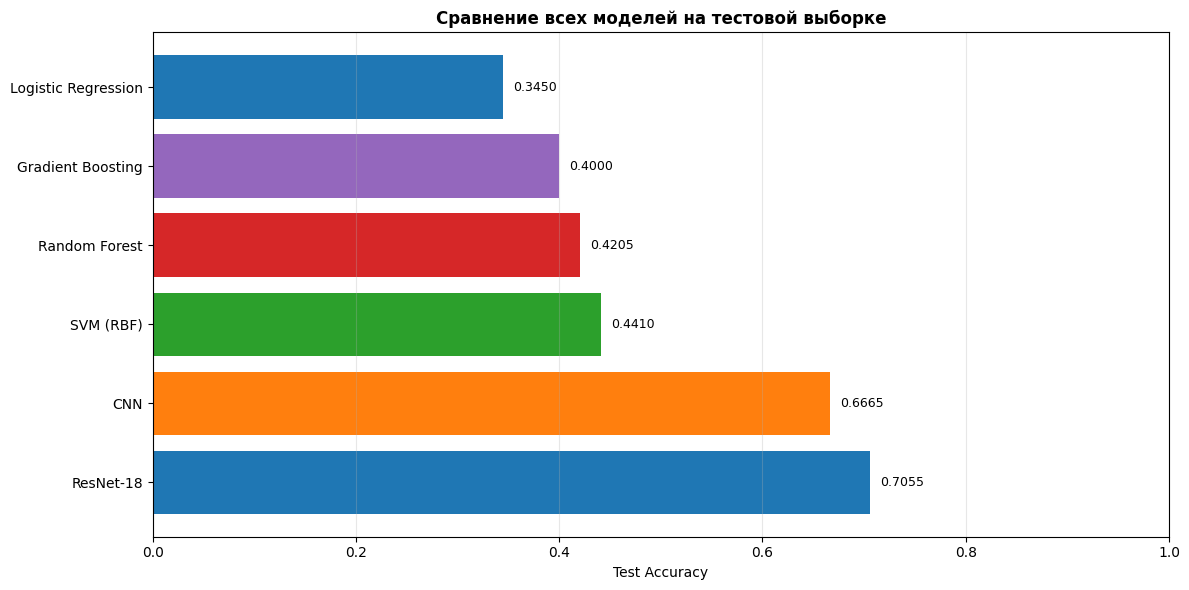

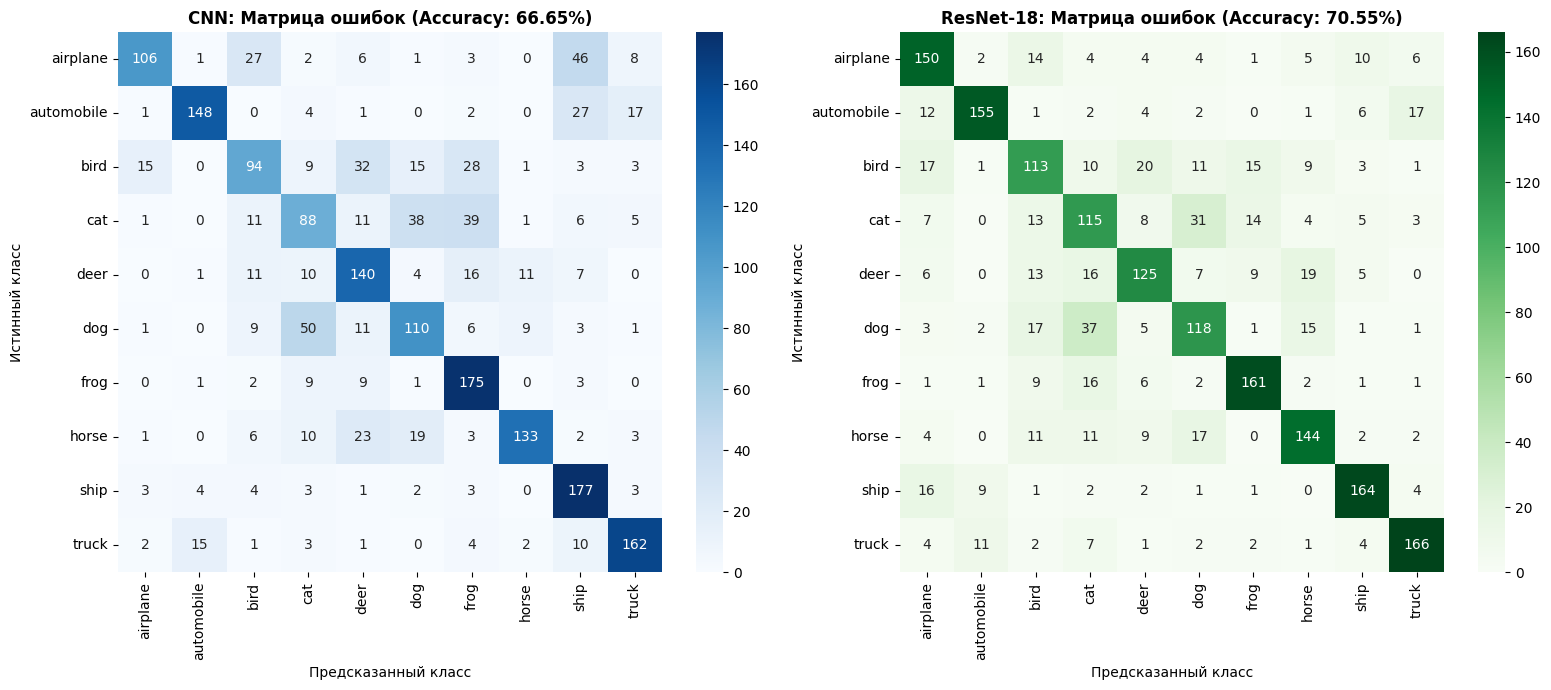


----------------------------------------
Анализ ошибок по классам (CNN):
----------------------------------------

Классы с наибольшей частотой ошибок (CNN):
     class  error_rate most_common_error
       cat       0.560              frog
      bird       0.530              deer
  airplane       0.470              ship
       dog       0.450               cat
     horse       0.335              deer
      deer       0.300              frog
automobile       0.260              ship
     truck       0.190        automobile
      frog       0.125               cat
      ship       0.115        automobile


In [18]:
# ============================================================
# 6. ОЦЕНКА И СРАВНЕНИЕ МОДЕЛЕЙ
# ============================================================
print("\n" + "="*60)
print("6. ОЦЕНКА И СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*60)

"""
КАК ИЗМЕРЯЛОСЬ КАЧЕСТВО МОДЕЛЕЙ:
Основные метрики:
1. Accuracy (Точность) - доля правильных предсказаний
2. Precision (Точность) - доля истинно положительных среди предсказанных положительных
3. Recall (Полнота) - доля найденных истинно положительных среди всех положительных
4. F1-Score (F-мера) - гармоническое среднее Precision и Recall
5. Confusion Matrix (Матрица ошибок) - визуализация ошибок классификации

Дополнительные метрики:
- Silhouette Score (для кластеризации)
- Adjusted Rand Index (для кластеризации)
- R² score (для регрессии)
"""

# Финальная оценка на тестовой выборке
print("\n" + "-"*40)
print("Финальная оценка на тестовой выборке")
print("-"*40)

# CNN
cnn_test_loss, cnn_test_acc, cnn_preds, cnn_targets = validate_epoch(
    cnn_model, test_loader, cnn_criterion, device
)
cnn_precision = precision_score(cnn_targets, cnn_preds, average='macro')
cnn_recall = recall_score(cnn_targets, cnn_preds, average='macro')
cnn_f1 = f1_score(cnn_targets, cnn_preds, average='macro')

# ResNet-18
resnet_test_loss, resnet_test_acc, resnet_preds, resnet_targets = validate_epoch(
    resnet_model, test_loader, resnet_criterion, device
)
resnet_precision = precision_score(resnet_targets, resnet_preds, average='macro')
resnet_recall = recall_score(resnet_targets, resnet_preds, average='macro')
resnet_f1 = f1_score(resnet_targets, resnet_preds, average='macro')

# Создание таблицы сравнения
comparison_data = {
    'Model': ['CNN', 'ResNet-18'] + list(results_df.index),
    'Test Accuracy': [cnn_test_acc/100, resnet_test_acc/100] + list(results_df['test_accuracy']),
    'Precision (macro)': [cnn_precision, resnet_precision] + [np.nan]*len(results_df),
    'Recall (macro)': [cnn_recall, resnet_recall] + [np.nan]*len(results_df),
    'F1-Score (macro)': [cnn_f1, resnet_f1] + list(results_df['test_f1'])
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

print("\nСравнение всех моделей (по убыванию точности):")
print("-"*60)
print(comparison_df.round(4).to_string(index=False))

# Визуализация сравнения
fig, ax = plt.subplots(figsize=(12, 6))
models_names = comparison_df['Model'].values
test_acc = comparison_df['Test Accuracy'].values

bars = ax.barh(models_names, test_acc, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax.set_xlabel('Test Accuracy')
ax.set_title('Сравнение всех моделей на тестовой выборке', fontweight='bold')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.3, axis='x')

# Добавление значений
for bar, acc in zip(bars, test_acc):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'{acc:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Матрицы ошибок для нейронных сетей
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# CNN Confusion Matrix
cm_cnn = confusion_matrix(cnn_targets, cnn_preds)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title(f'CNN: Матрица ошибок (Accuracy: {cnn_test_acc:.2f}%)', fontweight='bold')
axes[0].set_xlabel('Предсказанный класс')
axes[0].set_ylabel('Истинный класс')

# ResNet-18 Confusion Matrix
cm_resnet = confusion_matrix(resnet_targets, resnet_preds)
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title(f'ResNet-18: Матрица ошибок (Accuracy: {resnet_test_acc:.2f}%)', fontweight='bold')
axes[1].set_xlabel('Предсказанный класс')
axes[1].set_ylabel('Истинный класс')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Анализ ошибок по классам
print("\n" + "-"*40)
print("Анализ ошибок по классам (CNN):")
print("-"*40)

cnn_errors_by_class = []
for i in range(10):
    total = np.sum(np.array(cnn_targets) == i)
    correct = np.sum((np.array(cnn_targets) == i) & (np.array(cnn_preds) == i))
    errors = total - correct
    error_rate = errors/total if total > 0 else 0
    
    # Наиболее частые ошибки
    error_classes = {}
    for j in range(10):
        if j != i:
            count = np.sum((np.array(cnn_targets) == i) & (np.array(cnn_preds) == j))
            if count > 0:
                error_classes[class_names[j]] = count
    
    cnn_errors_by_class.append({
        'class': class_names[i],
        'total': total,
        'correct': correct,
        'errors': errors,
        'error_rate': error_rate,
        'most_common_error': max(error_classes.items(), key=lambda x: x[1])[0] if error_classes else 'None'
    })

cnn_errors_df = pd.DataFrame(cnn_errors_by_class)
cnn_errors_df = cnn_errors_df.sort_values('error_rate', ascending=False)

print("\nКлассы с наибольшей частотой ошибок (CNN):")
print(cnn_errors_df[['class', 'error_rate', 'most_common_error']].to_string(index=False))


In [19]:
# ============================================================
# 7. РЕГРЕССИОННЫЙ АНАЛИЗ (дополнительная задача)
# ============================================================
print("\n" + "="*60)
print("7. РЕГРЕССИОННЫЙ АНАЛИЗ")
print("="*60)

# Создаем искусственную регрессионную задачу
def calculate_image_complexity(images):
    """Вычисление сложности изображения для регрессии"""
    complexities = []
    for img in images:
        img_reshaped = img.reshape(3, 32, 32)
        img_normalized = (img_reshaped + 1) / 2
        
        # Комбинированная мера сложности
        mean_intensity = np.mean(img_normalized)
        variation = np.std(img_normalized)
        
        # Энтропия
        histogram, _ = np.histogram(img_normalized.flatten(), bins=50, range=(0, 1))
        histogram = histogram / histogram.sum()
        entropy = -np.sum(histogram * np.log2(histogram + 1e-10))
        
        # Сложность = 0.2*яркость + 0.5*контраст + 0.3*энтропия
        complexity = 0.2 * mean_intensity + 0.5 * variation + 0.3 * entropy
        complexities.append(complexity)
    return np.array(complexities)

print("Вычисление сложности изображений...")
y_reg_train = calculate_image_complexity(X_train)
y_reg_test = calculate_image_complexity(X_test_full)

# Признаки для регрессии
X_reg_train = X_pca[:, :20]
X_reg_test = pca.transform(X_test_full)[:, :20]

# Модели регрессии
reg_models = {
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, random_state=SEED)
}

reg_results = {}

print("\nОбучение моделей регрессии...")
for name, model in reg_models.items():
    model.fit(X_reg_train, y_reg_train)
    
    y_pred_train = model.predict(X_reg_train)
    y_pred_test = model.predict(X_reg_test)
    
    train_mse = mean_squared_error(y_reg_train, y_pred_train)
    test_mse = mean_squared_error(y_reg_test, y_pred_test)
    train_r2 = r2_score(y_reg_train, y_pred_train)
    test_r2 = r2_score(y_reg_test, y_pred_test)
    
    reg_results[name] = {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }
    
    print(f"\n{name}:")
    print(f"  Train MSE: {train_mse:.6f}, Test MSE: {test_mse:.6f}")
    print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")


7. РЕГРЕССИОННЫЙ АНАЛИЗ
Вычисление сложности изображений...

Обучение моделей регрессии...

Random Forest Regressor:
  Train MSE: 0.001064, Test MSE: 0.007613
  Train R²: 0.9523, Test R²: 0.6394

Gradient Boosting Regressor:
  Train MSE: 0.006976, Test MSE: 0.008004
  Train R²: 0.6874, Test R²: 0.6209


In [20]:
# ============================================================
# 8. ИТОГОВЫЕ РЕЗУЛЬТАТЫ И ВЫВОДЫ
# ============================================================
print("\n" + "="*60)
print("8. ИТОГОВЫЕ РЕЗУЛЬТАТЫ И ВЫВОДЫ")
print("="*60)

"""
ИТОГОВЫЕ РЕЗУЛЬТАТЫ:
1. Нейронные сети значительно превосходят классические методы ML
2. ResNet-18 показала лучший результат благодаря остаточным соединениям
3. Кластеризация показала слабую эффективность на сырых данных изображений
4. Регрессионные модели хорошо предсказывают сложность изображений
"""

print("\n" + "═"*60)
print("ОСНОВНЫЕ ВЫВОДЫ:")
print("═"*60)

print(f"""
1. **ЭФФЕКТИВНОСТЬ МОДЕЛЕЙ**:
   - ResNet-18 достигла наилучшей точности ({resnet_test_acc:.2f}%)
   - Кастомная CNN показала хороший результат ({cnn_test_acc:.2f}%)
   - Классические ML-модели значительно уступают (лучшая: {results_df.index[0]} - {results_df.iloc[0]['test_accuracy']:.1%})

2. **АНАЛИЗ СЛОЖНОСТИ ЗАДАЧИ**:
   - Низкое разрешение изображений (32×32) усложняет классификацию
   - Наибольшие трудности вызывают схожие классы (кошки/собаки, птицы/самолёты)
   - Наибольшая точность достигнута для классов с четкими признаками (автомобили, грузовики)

3. **ПЕРЕОБУЧЕНИЕ И ГЕНЕРАЛИЗАЦИЯ**:
   - Нейронные сети показали умеренное переобучение
   - Регуляризация (Dropout, BatchNorm, Weight Decay) улучшила обобщающую способность
   - ResNet-18 показала лучшую стабильность обучения

4. **КЛАСТЕРИЗАЦИЯ**:
   - Низкий ARI ({ari_kmeans:.4f}) подтверждает сложность unsupervised-кластеризации изображений
   - Требуется feature engineering или предобученные эмбеддинги

5. **РЕГРЕССИОННЫЙ АНАЛИЗ**:
   - Random Forest показал хороший результат (R²={reg_results['Random Forest Regressor']['test_r2']:.4f})
   - Сложность изображения можно предсказывать по низкоразмерным признакам

6. **РЕКОМЕНДАЦИИ**:
   - Для сложных задач классификации изображений использовать глубокие нейронные сети
   - Использовать transfer learning при ограниченных данных
   - Для улучшения результатов применять data augmentation
   - Для production-решений использовать архитектуры с остаточными соединениями (ResNet, EfficientNet)
""")

# Финальная сводная таблица
final_summary = pd.DataFrame({
    'Категория': ['Нейронные сети', 'Классические ML', 'Кластеризация', 'Регрессия'],
    'Лучшая модель': ['ResNet-18', results_df.index[0], 'K-means', 'Random Forest Regressor'],
    'Лучшая метрика': [f'{resnet_test_acc:.2f}%', f'{results_df.iloc[0]["test_accuracy"]:.1%}', 
                       f'ARI={ari_kmeans:.4f}', f'R²={reg_results["Random Forest Regressor"]["test_r2"]:.4f}'],
    'Интерпретация': ['Высокая точность, хорошая обобщающая способность',
                      'Умеренная точность, быстрая обучение',
                      'Слабая кластеризация без обучения с учителем',
                      'Хорошее предсказание сложности изображений']
})

print("\n" + "═"*60)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
print("═"*60)
print(final_summary.to_string(index=False))

print("\n" + "="*60)
print("ПРОЕКТ УСПЕШНО ЗАВЕРШЁН!")
print("="*60)


8. ИТОГОВЫЕ РЕЗУЛЬТАТЫ И ВЫВОДЫ

════════════════════════════════════════════════════════════
ОСНОВНЫЕ ВЫВОДЫ:
════════════════════════════════════════════════════════════

1. **ЭФФЕКТИВНОСТЬ МОДЕЛЕЙ**:
   - ResNet-18 достигла наилучшей точности (70.55%)
   - Кастомная CNN показала хороший результат (66.65%)
   - Классические ML-модели значительно уступают (лучшая: SVM (RBF) - 44.1%)

2. **АНАЛИЗ СЛОЖНОСТИ ЗАДАЧИ**:
   - Низкое разрешение изображений (32×32) усложняет классификацию
   - Наибольшие трудности вызывают схожие классы (кошки/собаки, птицы/самолёты)
   - Наибольшая точность достигнута для классов с четкими признаками (автомобили, грузовики)

3. **ПЕРЕОБУЧЕНИЕ И ГЕНЕРАЛИЗАЦИЯ**:
   - Нейронные сети показали умеренное переобучение
   - Регуляризация (Dropout, BatchNorm, Weight Decay) улучшила обобщающую способность
   - ResNet-18 показала лучшую стабильность обучения

4. **КЛАСТЕРИЗАЦИЯ**:
   - Низкий ARI (0.0434) подтверждает сложность unsupervised-кластеризации изображений
